<a href="https://colab.research.google.com/github/ChengAng2001/archivedjupyternotebooks/blob/main/XGboost_on_USAll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys 
import os
import time
from copy import deepcopy
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import model_selection
from sklearn.metrics.pairwise import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
original_data = pd.read_csv('/content/drive/MyDrive/NewFairML/data/USDataFrame.csv',dtype=object)

In [6]:
original_overdose_data_with_original_index = pd.read_csv('/content/drive/MyDrive/NewFairML/data/USAllCnty_SelectedByOverdose.csv',dtype=object)
original_overdose_data_with_original_index.columns = ['Original_index'] + original_overdose_data_with_original_index.columns[1:].tolist()
original_overdose_data = original_overdose_data_with_original_index.drop('Original_index',axis=1)

In [7]:
original_data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
original_overdose_data_with_original_index.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
original_overdose_data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

In [8]:
original_data['General_Manner_of_death'].unique()

array(['7', '2', '1', '3', '4', '5', ' '], dtype=object)

In [9]:
original_data['General_Manner_of_death'].value_counts()

7    20918565
      3631184
1     1437477
2      437530
3      186964
5      115775
4       41300
Name: General_Manner_of_death, dtype: int64

In [10]:
original_overdose_data_with_original_index['The_Decedent_Education'].unique()

array(['12 0', '14 0', '17 0', '09 0', '15 0', '10 0', '16 0', '11 0',
       '13 0', '99 0', '08 0', '07 0', '05 0', '01 0', '06 0', '00 0',
       '  41', '  61', '  21', '  31', '  51', '  11', '  91', '  81',
       '  71', '03 0', '04 0', '02 0'], dtype=object)

In [11]:
original_no_overdose_data = original_data[~original_data.index.isin(original_overdose_data_with_original_index['Original_index'])]

In [12]:
original_overdose_data['General_Manner_of_death'].count()

539005

In [13]:
original_no_overdose_data['General_Manner_of_death'].count()

26768795

In [14]:
def data_split(data_set):
  x, validation = model_selection.train_test_split(data_set, test_size=0.2)
  train, test = model_selection.train_test_split(x, test_size=0.125)
  return train, validation, test

In [15]:
original_no_overdose_data=original_no_overdose_data.sample(1000000)

In [16]:
train_unbalanced_class_0, validation_unbalanced_class_0, test_unbalanced_class_0 = data_split(original_no_overdose_data)
train_unbalanced_class_1, validation_unbalanced_class_1, test_unbalanced_class_1 = data_split(original_overdose_data)

train_unbalanced_class_0.insert(0, "y_value", pd.DataFrame(np.zeros(len(train_unbalanced_class_0),dtype=int)))
validation_unbalanced_class_0.insert(0, "y_value", pd.DataFrame(np.zeros(len(validation_unbalanced_class_0),dtype=int)))
test_unbalanced_class_0.insert(0, "y_value", pd.DataFrame(np.zeros(len(test_unbalanced_class_0),dtype=int)))
train_unbalanced_class_1.insert(0, "y_value", pd.DataFrame(np.ones(len(train_unbalanced_class_1),dtype=int)))
validation_unbalanced_class_1.insert(0, "y_value", pd.DataFrame(np.ones(len(validation_unbalanced_class_1),dtype=int)))
test_unbalanced_class_1.insert(0, "y_value", pd.DataFrame(np.ones(len(test_unbalanced_class_1),dtype=int)))

In [ ]:
'''
train_unbalanced_class_0_x = train_unbalanced_class_0.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code']).sample(n=2000)
train_unbalanced_class_0_y = pd.DataFrame(np.zeros(len(train_unbalanced_class_0_x),dtype=int))

validation_unbalanced_class_0_x = validation_unbalanced_class_0.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code']).sample(n=2000)
validation_unbalanced_class_0_y = pd.DataFrame(np.zeros(len(validation_unbalanced_class_0_x),dtype=int))

test_unbalanced_class_0_x = test_unbalanced_class_0.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code']).sample(n=2000)
test_unbalanced_class_0_y = pd.DataFrame(np.zeros(len(test_unbalanced_class_0_x),dtype=int))

train_unbalanced_class_1_x = train_unbalanced_class_1.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code'])
train_unbalanced_class_1_y = pd.DataFrame(np.ones(len(train_unbalanced_class_1_x),dtype=int))

validation_unbalanced_class_1_x = validation_unbalanced_class_1.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code'])
validation_unbalanced_class_1_y = pd.DataFrame(np.ones(len(validation_unbalanced_class_1_x),dtype=int))

test_unbalanced_class_1_x = test_unbalanced_class_1.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code'])
test_unbalanced_class_1_y = pd.DataFrame(np.ones(len(test_unbalanced_class_1_x),dtype=int))
'''

In [ ]:
validation_unbalanced_class_1

In [19]:
train_unbalanced_class_0['General_Manner_of_death'].value_counts()

7    546691
      95078
1     37696
2     11512
3      4829
5      3110
4      1084
Name: General_Manner_of_death, dtype: int64

In [20]:
train_unbalanced_class_0=train_unbalanced_class_0.sample(len(train_unbalanced_class_1))
validation_unbalanced_class_0=validation_unbalanced_class_0.sample(len(validation_unbalanced_class_1))
test_unbalanced_class_0=test_unbalanced_class_0.sample(len(test_unbalanced_class_1))
train_unbalanced_class_1=train_unbalanced_class_1.sample(len(train_unbalanced_class_1))
validation_unbalanced_class_1=validation_unbalanced_class_1.sample(len(validation_unbalanced_class_1))
test_unbalanced_class_1=test_unbalanced_class_1.sample(len(test_unbalanced_class_1))

In [21]:
train_unbalanced_class_0['General_Manner_of_death'].value_counts()

7    294667
      51353
1     20188
2      6245
3      2606
5      1663
4       581
Name: General_Manner_of_death, dtype: int64

In [22]:
train_before_sample=pd.concat([train_unbalanced_class_0,train_unbalanced_class_1])
validaton_before_sample=pd.concat([validation_unbalanced_class_0,validation_unbalanced_class_1])
test_before_sample=pd.concat([test_unbalanced_class_0,test_unbalanced_class_1])

In [23]:
train_unbalanced_class_0['General_Manner_of_death']

8840701     1
12448126    7
14297294    7
17046310    7
15945436     
           ..
21589173    7
4299966     7
12442346    7
1249594     7
3395154     7
Name: General_Manner_of_death, Length: 377303, dtype: object

In [24]:
train_unbalanced_class_0['General_Manner_of_death'].value_counts()

7    294667
      51353
1     20188
2      6245
3      2606
5      1663
4       581
Name: General_Manner_of_death, dtype: int64

In [25]:
train_before_sample['General_Manner_of_death'].value_counts()

1    329022
7    301538
      52513
2     42878
5     23953
3      3331
4      1371
Name: General_Manner_of_death, dtype: int64

In [26]:
train=train_before_sample.sample(frac=1)
validation=validaton_before_sample.sample(frac=1)
test=test_before_sample.sample(frac=1)

In [27]:
train['General_Manner_of_death'].value_counts()

1    329022
7    301538
      52513
2     42878
5     23953
3      3331
4      1371
Name: General_Manner_of_death, dtype: int64

In [28]:
'''
train_x=pd.concat([train_unbalanced_class_0_x,train_unbalanced_class_1_x])
train_y=pd.concat([train_unbalanced_class_0_y,train_unbalanced_class_1_y])
validation_x=pd.concat([validation_unbalanced_class_0_x,validation_unbalanced_class_1_x])
validation_y=pd.concat([validation_unbalanced_class_0_y,validation_unbalanced_class_1_y])
test_x=pd.concat([test_unbalanced_class_0_x,test_unbalanced_class_1_x])
test_y=pd.concat([test_unbalanced_class_0_y,test_unbalanced_class_1_y])
'''

'\ntrain_x=pd.concat([train_unbalanced_class_0_x,train_unbalanced_class_1_x])\ntrain_y=pd.concat([train_unbalanced_class_0_y,train_unbalanced_class_1_y])\nvalidation_x=pd.concat([validation_unbalanced_class_0_x,validation_unbalanced_class_1_x])\nvalidation_y=pd.concat([validation_unbalanced_class_0_y,validation_unbalanced_class_1_y])\ntest_x=pd.concat([test_unbalanced_class_0_x,test_unbalanced_class_1_x])\ntest_y=pd.concat([test_unbalanced_class_0_y,test_unbalanced_class_1_y])\n'

In [29]:
train_x=train.drop(columns=["Underlying_Cause_ICD-10_code", "Underlying_Cause_358_cause_recode", "Underlying_Cause_113_cause_recode", "Underlying_Cause_130_cause_recode", "Underlying_Cause_39_cause_recode", "Multiple_Conditions_Entity-Axis_conditions_Number_of", "Multiple_Conditions_Entity-Axis_conditions_The_conditions", "Multiple_Conditions_Record-Axis_conditions_Number_of", "Multiple_Conditions_Record-Axis_conditions_The_conditions", "Other_medical_items_Place_of_injury", "Other_medical_items_Injury_at_work", "Other_medical_items_Method_of_disposition", "Other_medical_items_Autopsy", "Other_medical_items_Certifier", "Other_medical_items_Tobacco_use", "Other_medical_items_Pregnancy_status", "Other_medical_items_Activity_code"]).sample(n=len(train))
train_y = train_x["y_value"]
train_x=train_x.drop(columns=["y_value"])

validation_x=validation.drop(columns=["Underlying_Cause_ICD-10_code", "Underlying_Cause_358_cause_recode", "Underlying_Cause_113_cause_recode", "Underlying_Cause_130_cause_recode", "Underlying_Cause_39_cause_recode", "Multiple_Conditions_Entity-Axis_conditions_Number_of", "Multiple_Conditions_Entity-Axis_conditions_The_conditions", "Multiple_Conditions_Record-Axis_conditions_Number_of", "Multiple_Conditions_Record-Axis_conditions_The_conditions", "Other_medical_items_Place_of_injury", "Other_medical_items_Injury_at_work", "Other_medical_items_Method_of_disposition", "Other_medical_items_Autopsy", "Other_medical_items_Certifier", "Other_medical_items_Tobacco_use", "Other_medical_items_Pregnancy_status", "Other_medical_items_Activity_code"]).sample(n=len(validation))
validation_y = validation_x["y_value"]
validation_x=validation_x.drop(columns=["y_value"])

test_x=test.drop(columns=["Underlying_Cause_ICD-10_code", "Underlying_Cause_358_cause_recode", "Underlying_Cause_113_cause_recode", "Underlying_Cause_130_cause_recode", "Underlying_Cause_39_cause_recode", "Multiple_Conditions_Entity-Axis_conditions_Number_of", "Multiple_Conditions_Entity-Axis_conditions_The_conditions", "Multiple_Conditions_Record-Axis_conditions_Number_of", "Multiple_Conditions_Record-Axis_conditions_The_conditions", "Other_medical_items_Place_of_injury", "Other_medical_items_Injury_at_work", "Other_medical_items_Method_of_disposition", "Other_medical_items_Autopsy", "Other_medical_items_Certifier", "Other_medical_items_Tobacco_use", "Other_medical_items_Pregnancy_status", "Other_medical_items_Activity_code"]).sample(n=len(test))
test_y = test_x["y_value"]
test_x=test_x.drop(columns=["y_value"])

In [30]:
train_x['General_Manner_of_death']

6027161     7
79709       1
4582191     7
20715207    7
121665      1
           ..
14266536    7
137715      1
147797      2
3570733     7
15699671     
Name: General_Manner_of_death, Length: 754606, dtype: object

In [31]:
train_x['General_Manner_of_death'].value_counts()

1    329022
7    301538
      52513
2     42878
5     23953
3      3331
4      1371
Name: General_Manner_of_death, dtype: int64

In [32]:
train_x['General_Manner_of_death'].count()

754606

In [33]:
numerical_features = [x for x in train_x.columns if train_x[x].dtype == float]
category_features = [x for x in train_x.columns if train_x[x].dtype != float]

In [34]:
def get_mapfunction(x):
    mapp = dict(zip(x.unique().tolist(),
         range(len(x.unique().tolist()))))
    def mapfunction(y):
        if y in mapp:
            return mapp[y]
        else:
            return -1
    return mapfunction
train_x_hashed=deepcopy(train_x)
validation_x_hashed=deepcopy(validation_x)
test_x_hashed=deepcopy(test_x)

for i in category_features:
    train_x_hashed[i] = train_x[i].apply(get_mapfunction(train_x[i]))
    validation_x_hashed[i] = validation_x[i].apply(get_mapfunction(validation_x[i]))
    test_x_hashed[i] = test_x[i].apply(get_mapfunction(test_x[i]))

In [35]:
train_x

,General_Record_Type,General_Resident_status,General_Place_of_death_and_decedents_status,General_Day_of_week_of_death,General_Data_year,General_Manner_of_death,Occurrence_State(FIPS),Occurrence_County(FIPS),Occurrence_Expanded_State,Occurrence_County_Population_size,...,Residence_Expanded_State,The_Decedent_Date_of_Death,The_Decedent_Sex,The_Decedent_Race,The_Decedent_Race_recode_40,The_Decedent_Age,The_Decedent_Marital_status,The_Decedent_State_or_country_of_birth,The_Decedent_Hispanic_Origin,The_Decedent_Education
6027161,1,1,4,6,2012,7,MA,021,MA,1,...,MA,01,M,01 11,01,1087 432311,S,MI MI,100 6,12 0
79709,1,1,4,2,2011,1,NY,085,YC,0,...,YC,10,M,01 11,01,1035 331306,S,NY NY,100 6,31
4582191,1,1,4,4,2011,7,TX,187,TX,4,...,TX,02,M,01 11,01,1066 391909,W,OK OK,100 6,41
20715207,1,1,2,6,2017,7,TX,113,TX,0,...,TX,09,F,02 32,02,1054 361607,S,TX TX,100 7,31
121665,1,1,9,6,2013,1,AL,023,AL,6,...,AL,02,M,02 32,02,1069 391909,W,AL AL,100 7,03 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14266536,1,1,6,2,2015,7,NC,183,NC,1,...,NC,05,F,01 11,01,1090 442411,W,NC NC,100 6,41
137715,1,1,4,7,2013,1,KY,117,KY,3,...,KY,07,M,01 11,01,1035 331306,S,CA CA,100 6,11
147797,1,1,4,3,2013,2,NM,061,NM,4,...,NM,09,F,01 11,01,1062 381808,M,ZZ ZZ,100 6,31
3570733,1,1,2,6,2011,7,MD,033,MD,1,...,MD,10,M,01 11,01,1065 391909,M,NH NH,100 6,12 0


In [36]:
train_x_hashed

,General_Record_Type,General_Resident_status,General_Place_of_death_and_decedents_status,General_Day_of_week_of_death,General_Data_year,General_Manner_of_death,Occurrence_State(FIPS),Occurrence_County(FIPS),Occurrence_Expanded_State,Occurrence_County_Population_size,...,Residence_Expanded_State,The_Decedent_Date_of_Death,The_Decedent_Sex,The_Decedent_Race,The_Decedent_Race_recode_40,The_Decedent_Age,The_Decedent_Marital_status,The_Decedent_State_or_country_of_birth,The_Decedent_Hispanic_Origin,The_Decedent_Education
6027161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79709,0,0,0,1,1,1,1,1,1,1,...,1,1,0,0,0,1,0,1,0,1
4582191,0,0,0,2,1,0,2,2,2,2,...,2,2,0,0,0,2,1,2,0,2
20715207,0,0,1,0,2,0,2,3,2,1,...,2,3,1,1,1,3,0,3,1,1
121665,0,0,2,0,3,1,3,4,3,3,...,3,2,0,1,1,4,1,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14266536,0,0,4,1,7,0,19,92,20,0,...,22,9,1,0,0,57,1,18,0,2
137715,0,0,0,3,3,1,34,25,35,4,...,36,4,0,0,0,1,0,6,0,7
147797,0,0,0,4,3,4,29,42,30,2,...,31,3,1,0,0,17,2,40,0,1
3570733,0,0,1,0,1,0,30,71,31,0,...,32,1,0,0,0,29,2,28,0,0


In [37]:
norm_train_x = normalize(train_x_hashed)
norm_validation_x = normalize(validation_x_hashed)
norm_test_x = normalize(validation_x_hashed)

In [38]:
train_x_hashed

,General_Record_Type,General_Resident_status,General_Place_of_death_and_decedents_status,General_Day_of_week_of_death,General_Data_year,General_Manner_of_death,Occurrence_State(FIPS),Occurrence_County(FIPS),Occurrence_Expanded_State,Occurrence_County_Population_size,...,Residence_Expanded_State,The_Decedent_Date_of_Death,The_Decedent_Sex,The_Decedent_Race,The_Decedent_Race_recode_40,The_Decedent_Age,The_Decedent_Marital_status,The_Decedent_State_or_country_of_birth,The_Decedent_Hispanic_Origin,The_Decedent_Education
6027161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79709,0,0,0,1,1,1,1,1,1,1,...,1,1,0,0,0,1,0,1,0,1
4582191,0,0,0,2,1,0,2,2,2,2,...,2,2,0,0,0,2,1,2,0,2
20715207,0,0,1,0,2,0,2,3,2,1,...,2,3,1,1,1,3,0,3,1,1
121665,0,0,2,0,3,1,3,4,3,3,...,3,2,0,1,1,4,1,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14266536,0,0,4,1,7,0,19,92,20,0,...,22,9,1,0,0,57,1,18,0,2
137715,0,0,0,3,3,1,34,25,35,4,...,36,4,0,0,0,1,0,6,0,7
147797,0,0,0,4,3,4,29,42,30,2,...,31,3,1,0,0,17,2,40,0,1
3570733,0,0,1,0,1,0,30,71,31,0,...,32,1,0,0,0,29,2,28,0,0


In [39]:
norm_train_x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.24253563, 0.        ,
        0.24253563],
       [0.        , 0.        , 0.        , ..., 0.27216553, 0.        ,
        0.27216553],
       ...,
       [0.        , 0.        , 0.        , ..., 0.40042066, 0.        ,
        0.01001052],
       [0.        , 0.        , 0.00774659, ..., 0.21690442, 0.        ,
        0.        ],
       [0.        , 0.        , 0.03590948, ..., 0.02693211, 0.        ,
        0.00897737]])

Accuracy: 93.78%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


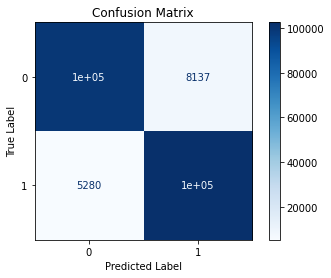

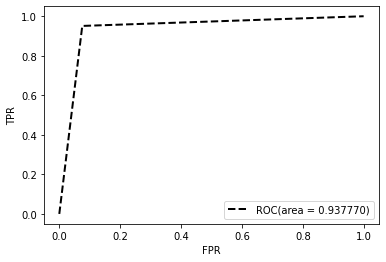

0.9380772926618932
0.9377695939740819


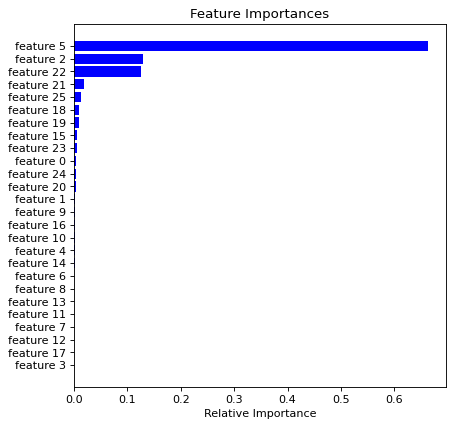

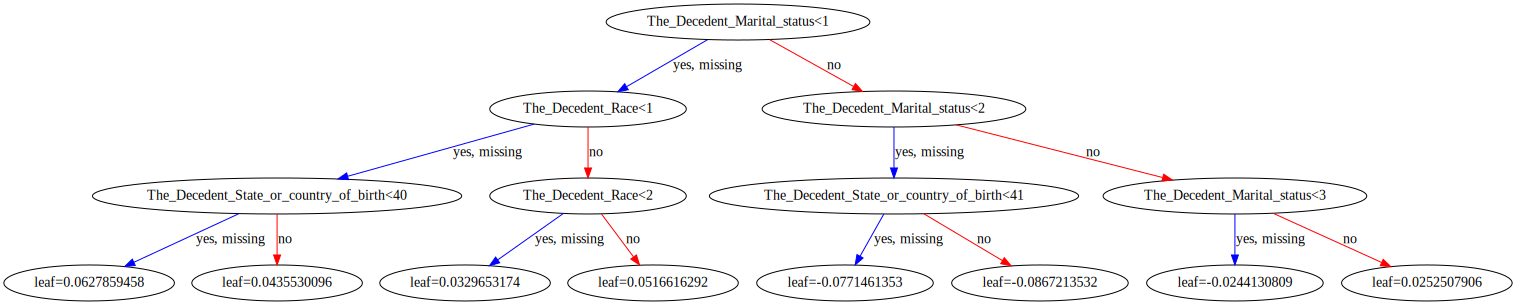

In [40]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=2, random_state=30)

xgb_model.fit(train_x_hashed, train_y)

# make predictions for test data
y_pred = xgb_model.predict(validation_x_hashed)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(validation_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

color = 'black'
matrix = plot_confusion_matrix(xgb_model, validation_x_hashed, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()



fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()



print(precision_score(validation_y, y_pred, average='macro'))
print(recall_score(validation_y, y_pred, average='macro'))



figure(figsize=(6, 6), dpi=80)

features = [f"feature {i}" for i in range(train_x_hashed.shape[1])]
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



xgb.to_graphviz(xgb_model)

In [45]:
print(category_features[5])
print(category_features[2])
print(category_features[22])
print(category_features[21])
print(category_features[25])
print(category_features[18])
print(category_features[19])
print(category_features[15])
print(category_features[23])
print(category_features[0])
print(category_features[24])
print(category_features[20])



General_Manner_of_death
General_Place_of_death_and_decedents_status
The_Decedent_Marital_status
The_Decedent_Age
The_Decedent_Education
The_Decedent_Sex
The_Decedent_Race
Residence_Met_or_Nonmet_county
The_Decedent_State_or_country_of_birth
General_Record_Type
The_Decedent_Hispanic_Origin
The_Decedent_Race_recode_40


Accuracy: 87.65%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


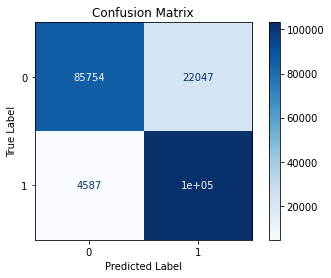

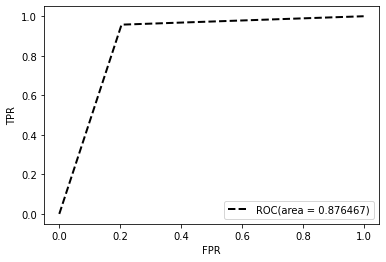

0.8866086086035027
0.8764668231278003


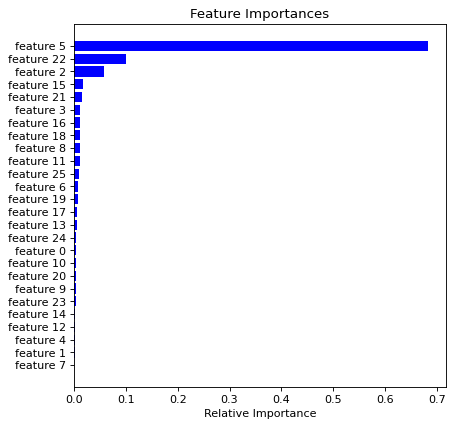

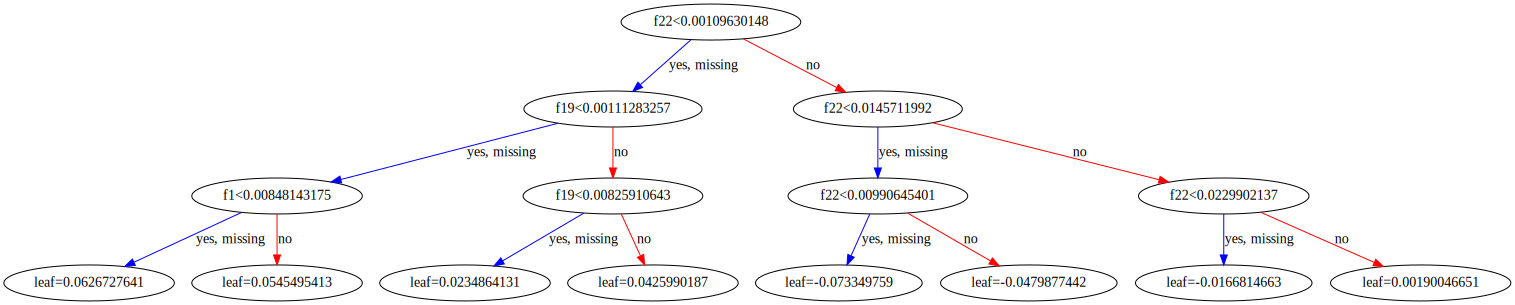

In [42]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=2, random_state=30)

xgb_model.fit(norm_train_x, train_y)

# make predictions for test data
y_pred = xgb_model.predict(norm_validation_x)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(validation_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

color = 'black'
matrix = plot_confusion_matrix(xgb_model, norm_validation_x, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()



fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()



print(precision_score(validation_y, y_pred, average='macro'))
print(recall_score(validation_y, y_pred, average='macro'))



figure(figsize=(6, 6), dpi=80)

features = [f"feature {i}" for i in range(norm_train_x.shape[1])]
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



xgb.to_graphviz(xgb_model)

In [43]:
train_x.iloc[: , 20:21]
train_x.iloc[: , 33:34]

""
6027161
79709
4582191
20715207
121665
...
14266536
137715
147797
3570733
